In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import typing
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import statsmodels.api as sm


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
data = pd.read_csv('../DATA/processed/dataset.csv', parse_dates=['date'])
data = data.set_index('date')

//home/anatoly/HDD/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (39,41,42) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [55]:
data.columns

Index(['P1_p10', 'P1_p25', 'P1_p50', 'P1_p75', 'P1_p90', 'P1', 'P1_filtr_mean',
       'P2_p10', 'P2_p25', 'P2_p50', 'P2_p75', 'P2_p90', 'P2', 'P2_filtr_mean',
       'temperature_p10', 'temperature_p25', 'temperature_p50',
       'temperature_p75', 'temperature_p90', 'temperature',
       'temperature_filtr_mean', 'humidity_p10', 'humidity_p25',
       'humidity_p50', 'humidity_p75', 'humidity_p90', 'humidity',
       'humidity_filtr_mean', 'pressure_p10', 'pressure_p25', 'pressure_p50',
       'pressure_p75', 'pressure_p90', 'pressure', 'pressure_filtr_mean',
       'temp_meteo', 'pres_meteo', 'hum_meteo', 'wind_direction', 'wind_speed',
       'precipitation', 'prec_amount', 'prec_time', 'visibility',
       'dew_point_temp'],
      dtype='object')

# Распределения признаков в датасете
## PM2.5

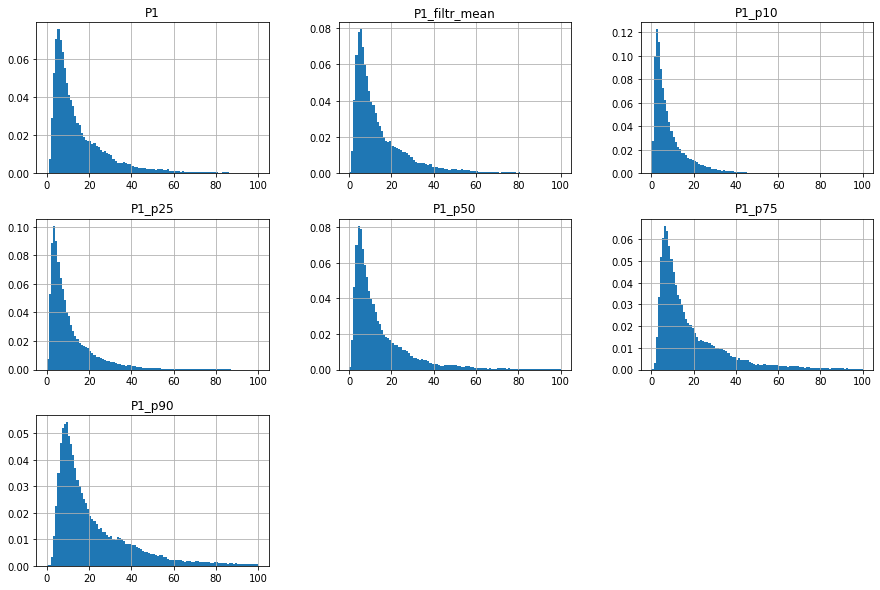

In [57]:
columns = ['P1', 'P1_filtr_mean', 'P1_p10', 'P1_p25', 'P1_p50', 'P1_p75', 'P1_p90']
_ = data.hist(column=columns, density=True, bins=100, figsize=(15, 10), range=(0,100))

P1_filtr_mean и p50 имеют похожее распределение, а P1 (среденне значение) имеет более тяжелый "хвост" из-за большего влияния выбросов.
## PM10

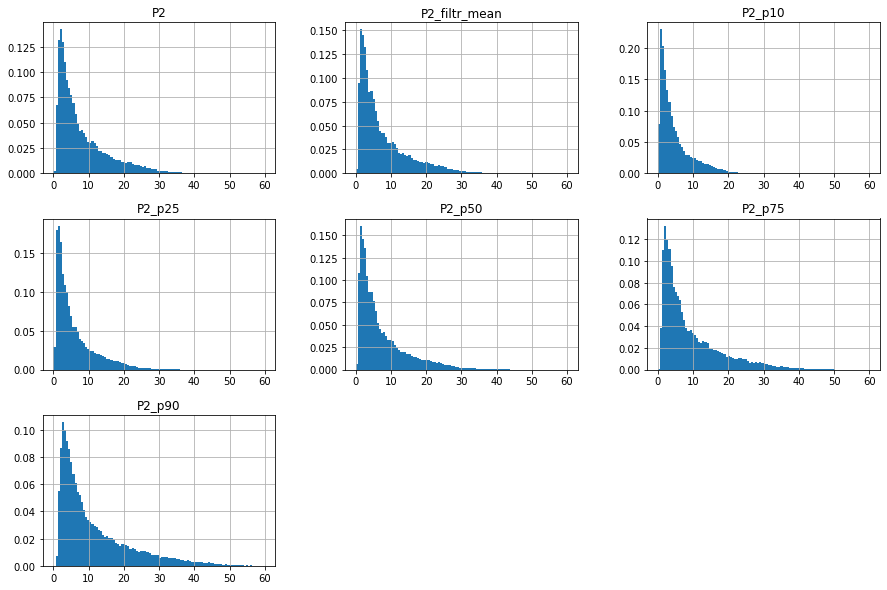

In [58]:
columns = ['P2', 'P2_filtr_mean', 'P2_p10', 'P2_p25', 'P2_p50', 'P2_p75', 'P2_p90']
_ = data.hist(column=columns, density=True, bins=100, figsize=(15, 10), range=(0,60))

Тут ситуация в целом аналогична PM2.5, но "хвосты" всех распределений ниже
## Humidity

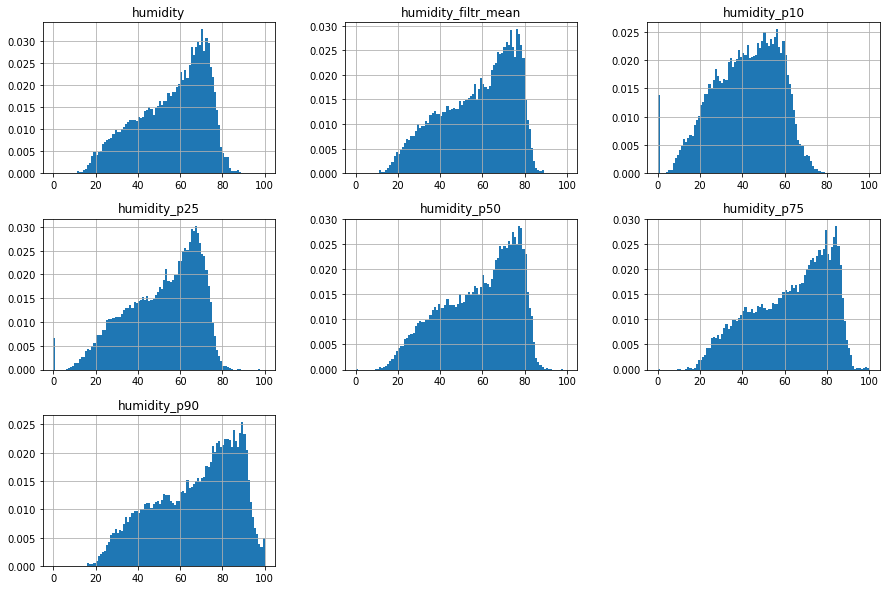

In [59]:
columns = ['humidity', 'humidity_filtr_mean', 'humidity_p10', 'humidity_p25',
       'humidity_p50', 'humidity_p75', 'humidity_p90']
_ = data.hist(column=columns, density=True, bins=100, figsize=(15, 10), range=(0,100))

## Temperature

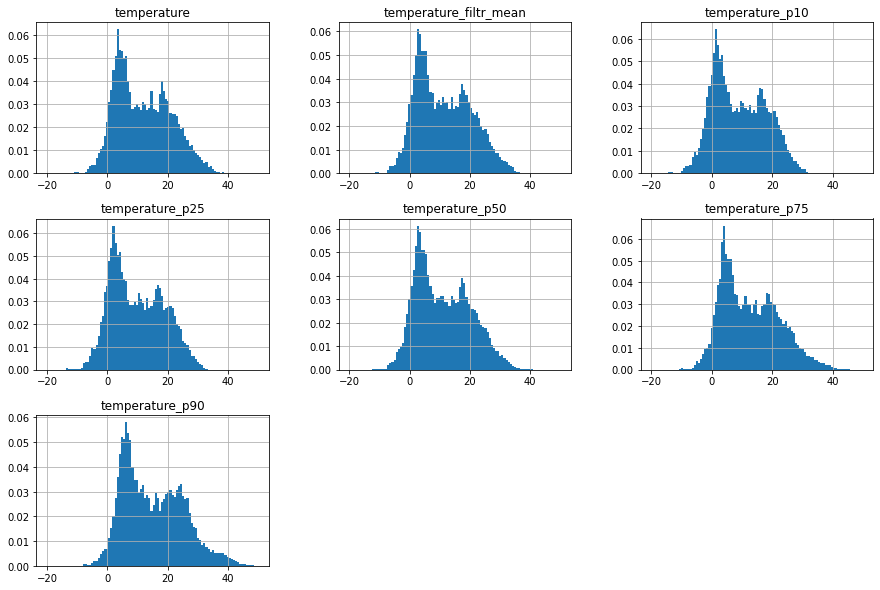

In [60]:
columns = [ 'temperature','temperature_filtr_mean','temperature_p10', 'temperature_p25', 'temperature_p50',
       'temperature_p75', 'temperature_p90']
_ = data.hist(column=columns, density=True, bins=100, figsize=(15, 10), range=(-20,50))

Все распределения имеют примерно одинаковый "хвост" со стороны низких температур, но temperature_filtr_mean и temperature_p50 имеют тяжелый "хвост" со стороны высоких температур чем обычное среднее - в сторону высоких температур больше выбросов.
## Pressure

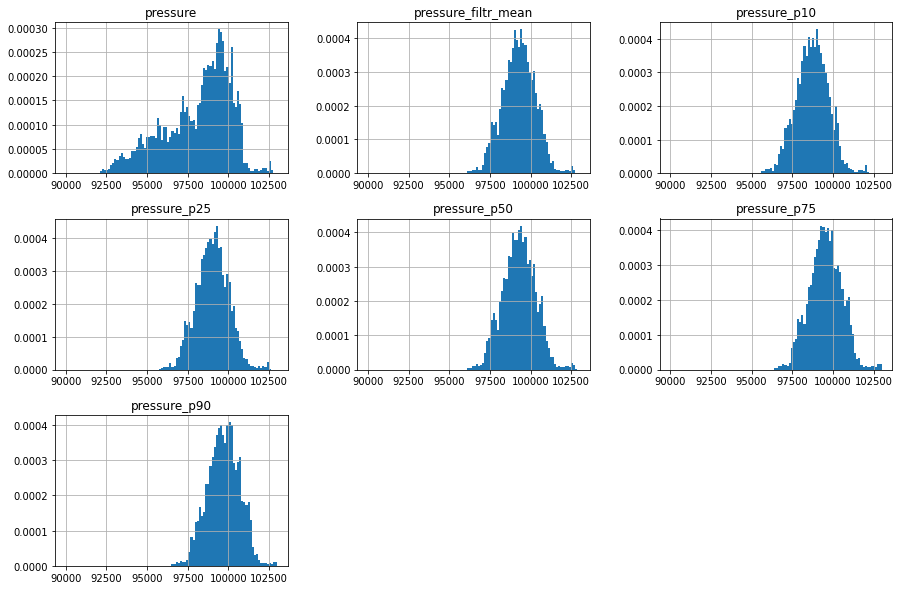

In [61]:
columns = ['pressure', 'pressure_filtr_mean',  'pressure_p10', 'pressure_p25', 'pressure_p50',
       'pressure_p75', 'pressure_p90']
_ = data.hist(column=columns, density=True, bins=100, figsize=(15, 10), range=(90000,103000))

Распределение среднего очень широкое, а центры распределений квантилей сильно смещены относительно
друг друга. Данные шумные, скорее всего из-за влияния высоты расположения датчика на показания.
## Meteo

In [62]:
wind_dir = {'Ветер, дующий с востока': 0,
            'Ветер, дующий с востоко-северо-востока': 45/2,
            'Ветер, дующий с северо-востока': 45,
            'Ветер, дующий с северо-северо-востока': 45 + 45/2,
            'Ветер, дующий с севера': 90,
            'Ветер, дующий с северо-северо-запад': 90 + 45/2,
            'Ветер, дующий с северо-запада': 135,
            'Ветер, дующий с западо-северо-запада': 135 + 45/2,
            'Ветер, дующий с запада': 180,
            'Ветер, дующий с западо-юго-запада': 180+45/2,
            'Ветер, дующий с юго-запада': 225,
            'Ветер, дующий с юго-юго-запада': 225 + 45/2,
            'Ветер, дующий с юга': 270,
            'Ветер, дующий с юго-юго-востока': 270 + 45/2,
            'Ветер, дующий с юго-востока': 315,
            'Ветер, дующий с востоко-юго-востока': 315 + 45/2,
            'Штиль, безветрие': None,
            }

data['pres_meteo'] = data.pres_meteo.fillna(method='bfill')
data['temp_meteo'] = data.temp_meteo.fillna(method='bfill')
data['hum_meteo'] = data.hum_meteo.fillna(method='bfill') 
data['prec_amount'] = data.prec_amount.fillna(method='bfill')
data.loc[data.prec_amount == 'Осадков нет', 'prec_amount'] = 0
data.loc[data.prec_amount == 'Следы осадков', 'prec_amount'] = 0
data['prec_amount'] = data.prec_amount.astype(float)
data['wind_direction'] = data.wind_direction.map(wind_dir)
data['wind_direction'] = data.wind_direction.fillna(method='bfill')


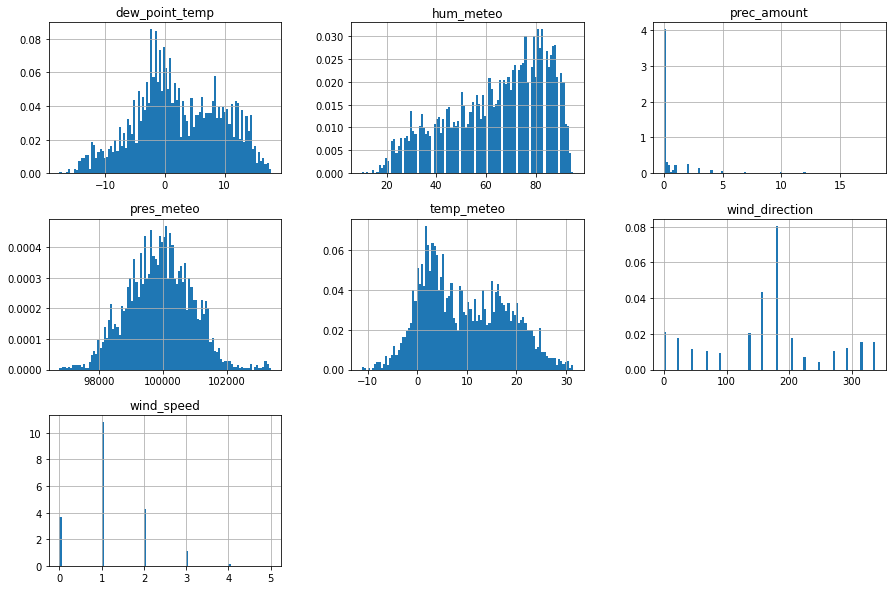

In [64]:
columns = ['temp_meteo', 'pres_meteo', 'hum_meteo', 'wind_direction',
           'wind_speed', 'prec_amount', 'dew_point_temp']
_ = data.hist(column=columns, density=True, bins=100, figsize=(15, 10))

# Влияние влажности на PM2.5 и PM10

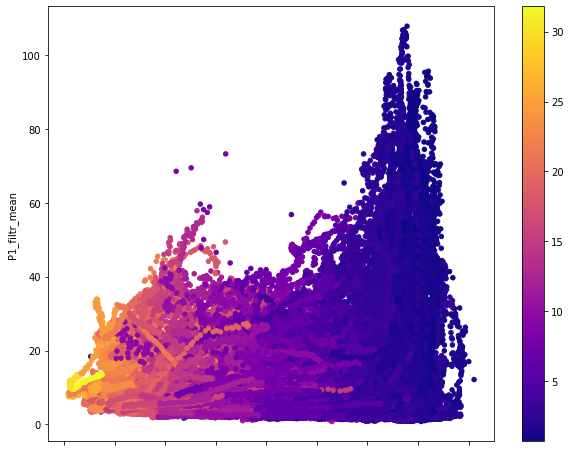

In [80]:
_ = data.plot.scatter( 'humidity_filtr_mean', 'P1_filtr_mean',
                  c=data.temp_meteo-data.dew_point_temp, colormap='plasma')

Цветом показана разница между текучей температурой и температурой точки росы. Видим, что при высокой влажности имеют место высокие значения концентрации частиц - датчик реагирует на капельки воды в воздухе. Тем не менее, высокое значение влажности не всегда означает высокие значения PM2.5

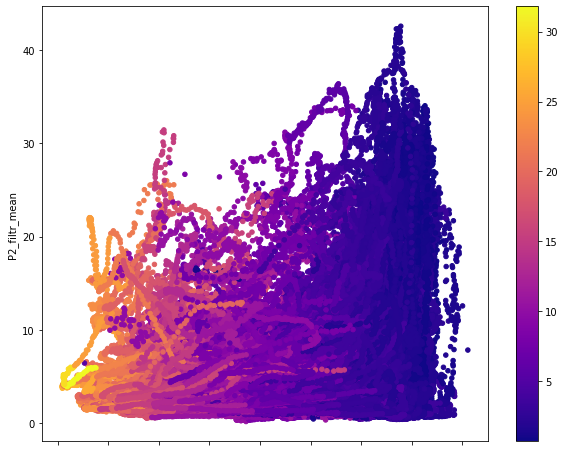

In [81]:
data.plot.scatter( 'humidity_filtr_mean', 'P2_filtr_mean',
                  c=data.temp_meteo-data.dew_point_temp, colormap='plasma')

На PM10 влажность влияет в меньшей степени - по-видимому, капельки частиц обычно меньше.

In [ ]:
data['hour'] = data.index.hour
data['month'] = data.index.month

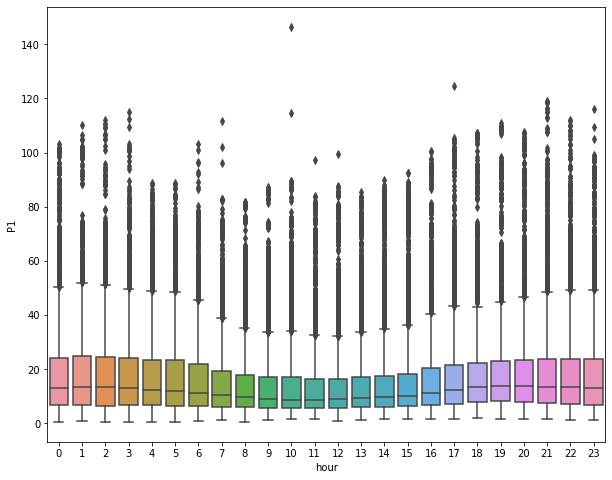

In [7]:
sns.boxplot(x='hour', y='P1', data=data)

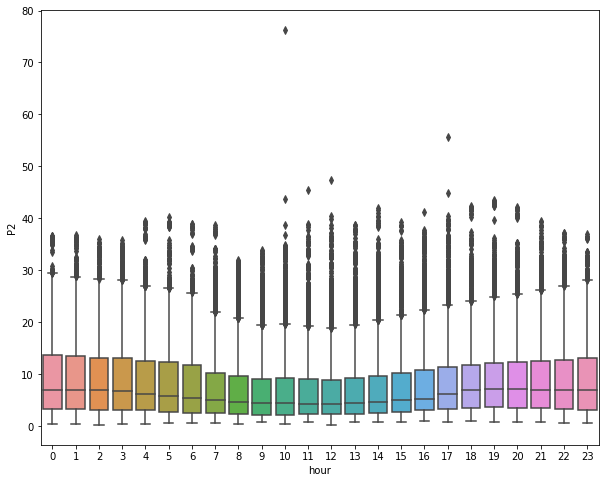

In [8]:
sns.boxplot(x='hour', y='P2', data=data)

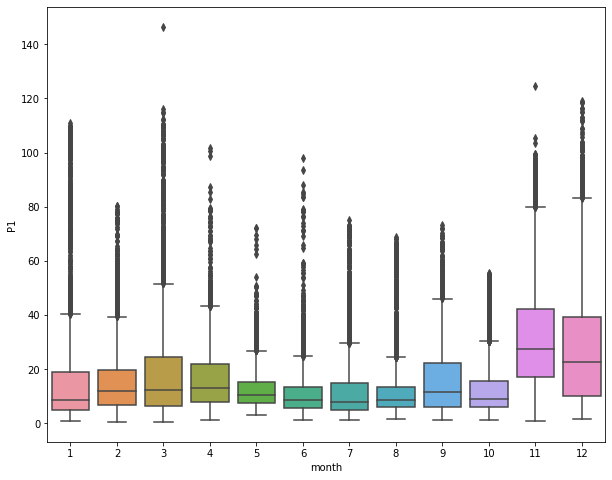

In [9]:
sns.boxplot(x='month', y='P1', data=data)

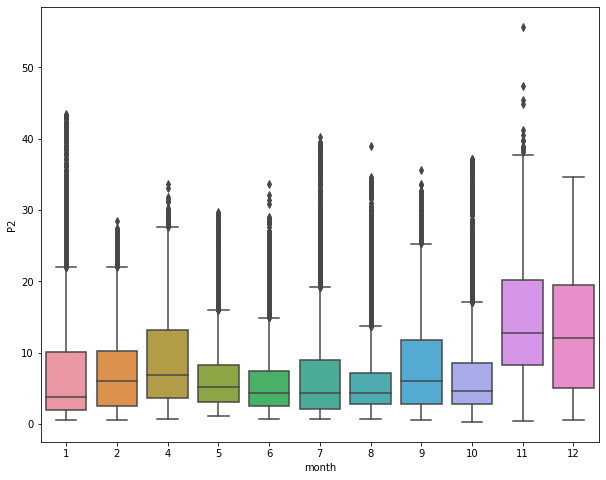

In [10]:
sns.boxplot(x='month', y='P2', data=data)

посмотрим на измение признаков погоды по месяцам

In [10]:
data['prec_amount'] = data.prec_amount.fillna(method='bfill')
data.loc[data.prec_amount == 'Осадков нет', 'prec_amount'] = 0
data.loc[data.prec_amount == 'Следы осадков', 'prec_amount'] = 0
data['prec_amount'] = data.prec_amount.astype(float)

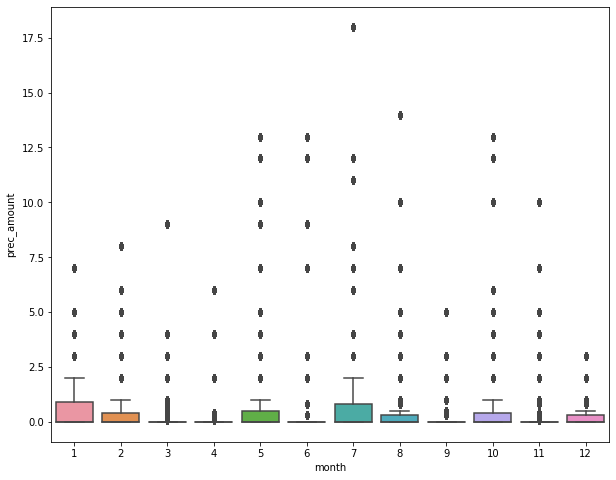

In [11]:
sns.boxplot(x='month', y='prec_amount', data=data)

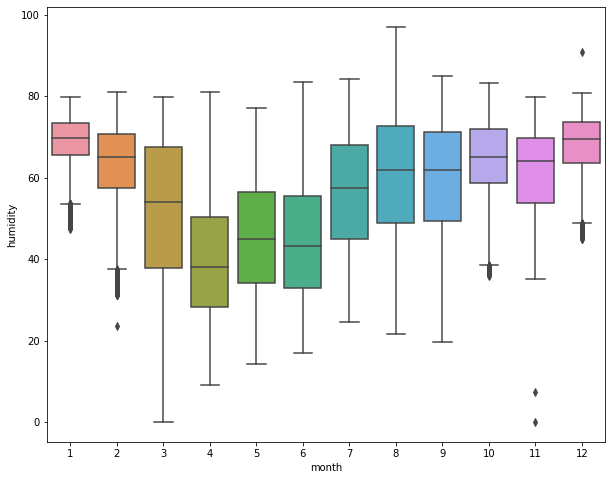

In [12]:
sns.boxplot(x='month', y='humidity', data=data)

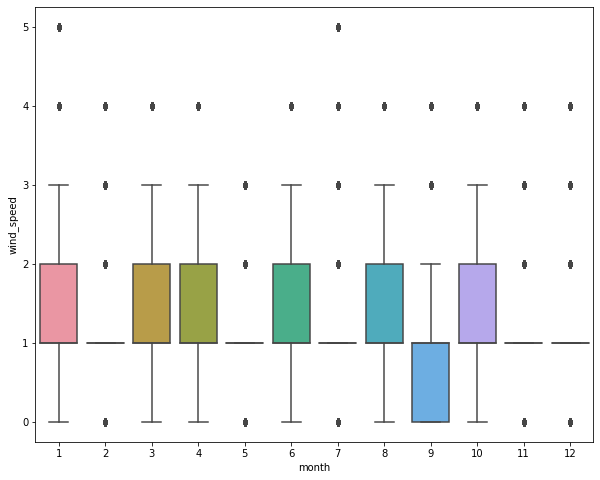

In [13]:
sns.boxplot(x='month', y='wind_speed', data=data)

# Anomalies distribution in time
Here we plot anomalies number by months and hours

In [14]:
wind_dir = {'Ветер, дующий с востока': 0,
            'Ветер, дующий с востоко-северо-востока': 45/2,
            'Ветер, дующий с северо-востока': 45,
            'Ветер, дующий с северо-северо-востока': 45 + 45/2,
            'Ветер, дующий с севера': 90,
            'Ветер, дующий с северо-северо-запад': 90 + 45/2,
            'Ветер, дующий с северо-запада': 135,
            'Ветер, дующий с западо-северо-запада': 135 + 45/2,
            'Ветер, дующий с запада': 180,
            'Ветер, дующий с западо-юго-запада': 180+45/2,
            'Ветер, дующий с юго-запада': 225,
            'Ветер, дующий с юго-юго-запада': 225 + 45/2,
            'Ветер, дующий с юга': 270,
            'Ветер, дующий с юго-юго-востока': 270 + 45/2,
            'Ветер, дующий с юго-востока': 315,
            'Ветер, дующий с востоко-юго-востока': 315 + 45/2,
            'Штиль, безветрие': None,
            }


def prepare_features(data: pd.DataFrame) -> pd.DataFrame:
    """Features preparation for anomaly detection and clustering"""
    # textual values encoding
    data['wind_direction'] = data.wind_direction.fillna(method='bfill')
    data['wind_direction'] = data.wind_direction.map(wind_dir)

    data['prec_amount'] = data.prec_amount.fillna(method='bfill')
    data.loc[data.prec_amount == 'Осадков нет', 'prec_amount'] = 0
    data.loc[data.prec_amount == 'Следы осадков', 'prec_amount'] = 0
    data['prec_amount'] = data.prec_amount.astype(float)

    data['dew_point_diff'] = data.temperature - data.dew_point_temp

    # fill missing value before PCA
    data['P1'] = data.P1.interpolate()
    data['P2'] = data.P2.interpolate()
    data['pressure'] = data.pressure.interpolate()
    data['temperature'] = data.temperature.interpolate()
    data['humidity'] = data.humidity.interpolate()
    return data

In [15]:
def anom_detector(time_series: pd.DataFrame, freq=round(60 * 25 / 5), quant=0.85) -> typing.List[pd.DataFrame]:
    """
    Anomaly detection by time-series decomposition.
    :param time_series: to series for anomaly search
    :param freq: frequency of decomposition
    :param quant: al moment with decomposition residual above this quantile is anomaly
    :return: list of anomaly series
    """
    time_series['P1'] = time_series.P1.interpolate()
    time_series['P1'] = time_series.P1.rolling(4, min_periods=1).mean()
    decomp = sm.tsa.seasonal_decompose(time_series.P1, model='additive', freq=freq, extrapolate_trend='freq')
    q = decomp.resid.quantile(quant)

    # find anomaly
    time_series['trend'] = decomp.trend
    time_series['seasonal'] = decomp.seasonal
    time_series['resid'] = decomp.resid
    time_series['anomaly'] = abs(time_series.resid) > q
    anomaly = time_series[time_series['anomaly']]

    # split anomaly on separate dataframe
    anomaly['gap'] = (anomaly.index.to_series().diff()) > pd.Timedelta(10, 'm')
    l_mod = pd.to_datetime(anomaly[anomaly.gap].index)
    l_mod = l_mod.insert(0, anomaly.index[0])
    l_mod = l_mod.insert(len(l_mod), anomaly.index[-1])
    ls = [anomaly[l_mod[n]:l_mod[n + 1]] for n in range(0, len(l_mod) - 1, 1)]
    ls = [i[:-1] for i in ls]
    ls = [i for i in ls if len(i) > 12]
    return ls

In [16]:
def get_anomaly_features(anom_list: typing.List[pd.DataFrame]) -> pd.DataFrame:
    anomdata = pd.DataFrame(index=[i for i in range(len(anom_list))])
    anomdata['max_P1'] = [i.P1.max() for i in anom_list]
    anomdata['min_P1'] = [i.P1.min() for i in anom_list]
    anomdata['min_P2'] = [i.P2.min() for i in anom_list]
    anomdata['max_P2'] = [i.P2.max() for i in anom_list]
    anomdata['mean_hum'] = [i.humidity.mean() for i in anom_list]
    anomdata['change_hum'] = [i.humidity.max() - i.humidity.min() for i in anom_list]
    anomdata['change_temp'] = [i.temperature.max() - i.temperature.min() for i in anom_list]
    anomdata['prec_amount'] = [i.prec_amount.mean() for i in anom_list]
    anomdata['max_w_speed'] = [i.wind_speed.max() for i in anom_list]
    anomdata['min_w_speed'] = [i.wind_speed.min() for i in anom_list]
    anomdata['w_dir_sin_max'] = [np.max(np.sin(i.wind_direction)) for i in anom_list]
    anomdata['w_dir_sin_mix'] = [np.min(np.sin(i.wind_direction)) for i in anom_list]
    anomdata['w_dir_cos_max'] = [np.max(np.cos(i.wind_direction)) for i in anom_list]
    anomdata['w_dir_cos_min'] = [np.min(np.cos(i.wind_direction)) for i in anom_list]
    anomdata['max_resid'] = [np.max(i.resid) for i in anom_list]
    anomdata['min_resid'] = [np.min(i.resid) for i in anom_list]
    return anomdata

In [17]:
import typing
# sel_columns = ['max_P1', 'min_P1', 'min_P2', 'max_P2', 'mean_hum', 'prec_amount',
#                       'max_w_speed', 'min_w_speed', 'change_hum','max_resid', 'min_resid']
sel_columns = ['mean_hum', 'prec_amount',
                       'max_w_speed', 'min_w_speed', 'change_hum','max_resid', 'min_resid']
class AnomalyCluster:
    """ Anomaly selection and cluster label prediction on test data"""

    def __init__(self, kmean: KMeans, pca: PCA):
        self.kmean = kmean
        self.pca = pca
        self.prepare_feture = prepare_features
        self.anom_detector = anom_detector
        self.get_anomaly_features = get_anomaly_features

    def get_anomaly(self, data: pd.DataFrame) -> typing.List[pd.DataFrame]:
        """Get time series (7-day length preferable, as used in train) and return list of anomaly dataframes"""
        data = self.prepare_feture(data)
        anomaly = self.anom_detector(data)
        return anomaly

    def get_clusters(self, anomlies: typing.List[pd.DataFrame]) -> typing.List[int]:
        """Det list of anomaly dataframes and return list of cluster labels"""
        anom_fetures = self.get_anomaly_features(anomlies)
        x = self.pca.transform(anom_fetures[sel_columns])
        clusters = self.kmean.predict(x)
        return clusters

In [18]:
with open('../models/kmean.obj', 'rb') as f:
    km = pickle.load(f)
with open('../models/pca.obj', 'rb') as f:
    pca = pickle.load(f)

In [19]:
model = AnomalyCluster(km, pca)

In [20]:
data = prepare_features(data)

//home/anatoly/HDD/anaconda3/envs/mlforair/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [21]:
weeks = [g for n, g in data.groupby(pd.Grouper(freq='7D'))]  # split dataset by 7 days series
anom_list = []
# for each series detect anomalies separately
for w in weeks[:-2]:
    # decomposition
    ls = anom_detector(w)
    anom_list = anom_list + ls

//home/anatoly/HDD/anaconda3/envs/mlforair/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
//home/anatoly/HDD/anaconda3/envs/mlforair/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
anom_starts = pd.DataFrame(index=[i for i in range(len(anom_list))])
anom_starts['time'] = [i.index[0] for i in anom_list]

In [23]:
anom_starts['month'] = anom_starts['time'].dt.month
anom_starts['hour'] = anom_starts['time'].dt.hour

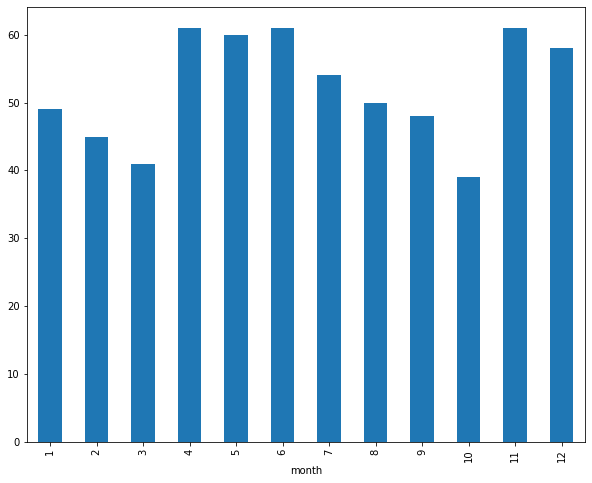

In [24]:
anom_starts.time.groupby(anom_starts.month).count().plot.bar()

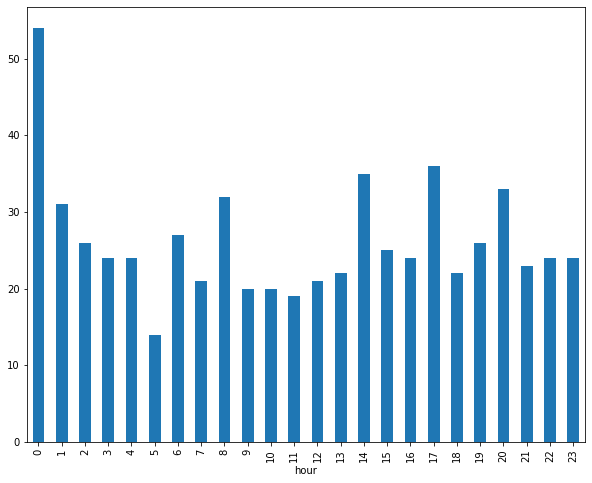

In [25]:
anom_starts.time.groupby(anom_starts.hour).count().plot.bar()